# Zadanie 2 - Optical Character Recognition
Napisz program przekształacający obraz w tekst, przyjmując następujące założenia:  
1. Na obrazie znajduje się tekst złożony z małych liter alfabetu łacińskiego oraz cyfr
2. Na obrazie występuje jeden typ i rozmiar czcionki
3. Weź pod uwagę czcionki szeryfowe i bezszeryfowe
4. W tekście występują znaki przestankowe: .,?!
5. Tekst składa się z wielu linii
6. Tekst może być obrócony (krzywo zeskanowany w całości)
7. Program powinien zwracać tekst wraz ze znakami białymi i znakami nowych linii
8. Program może raportować procent poprawnie rozpoznanych liter dla pre-definiowanych
obrazów testowych
9. Program powinien dodatkowo zliczać liczbę wystąpień każdej litery
10. Należy zastosować operację splotu i DFT albo inne metody (klasyfikacja)
11. Należy dokonać redukcji szumu na obrazie wejściowym

Wykorzystywane biblioteki:

In [1]:
import numpy as np
from numpy.fft import fft2, ifft2
from PIL import Image, ImageOps, ImageFont, ImageDraw
import matplotlib.pyplot as plt
from skimage import measure
from collections import defaultdict
import cv2
from functools import cmp_to_key

Globalna zmienna - string wszystkich znaków

In [2]:
CHARACTERS = "abcdefghijklmnopqrstuvwxyz0123456789?!.,"

Wczytuję obrazy za pomocą biblioteki Pillow

In [3]:
def load_image(path, invert=True):
    img = Image.open(path).convert("L")
    if invert:
        img = ImageOps.invert(img)
    return img

Wczytuję czcionki z plików o formacie .ttf
Przygotowałem dwa zestawy:
- bezszeryfową - Arial (fonts/arial.ttf)
- szeryfową - Times New Roman (fonts/times.ttf)

In [4]:
def load_font(name, size):
    return ImageFont.truetype(f'fonts/{name}.ttf', size)

Tworzę obraz z tekstem wykorzystując funkcje z biblioteki Pillow.  
Do funkcji można podać parametry noise (szum) i rotation (kąt obrotu tekstu na zdjęciu)

In [5]:
def generate_image_with_text(text, font_name, size, noise=0, rotation=0, inverted=False):
    font = load_font(font_name, size)
    length = int((max([font.getlength(line) for line in text.split('\n')])+10)*1.1)
    img = Image.new('L', (length, 1000), color='black')
    draw = ImageDraw.Draw(img)
    draw.text((10, 10), text, font=font, fill='white')
    # Crop image
    bbox = img.getbbox()
    img = img.crop(bbox)
    # Rotate image
    img = img.rotate(rotation, expand=True)
    # Reverse 
    img = ImageOps.invert(img)
    # Add padding
    img = ImageOps.expand(img, border=1, fill='white')
    # Add noise
    img = np.array(img)
    img = img + np.random.normal(0, noise, img.shape)
    img = np.clip(img, 0, 255)
    img = Image.fromarray(img.astype(np.uint8))
    # Invert colors
    img = ImageOps.invert(img) if inverted else img
    # Return image
    return img

## OCR

Obracam obraz znajdując prostokąt zawierający tekst i obracając go tak, by był równoległy do osi układu

In [6]:
def rotate_image(image):
    img = np.array(ImageOps.invert(image.copy()))
    coords = np.column_stack(np.where(img > 0))
    p1, p2, angle = cv2.minAreaRect(coords)
    if p1[1] < p2[1]: angle = -angle
    else: angle = 90 - angle
    return image.rotate(angle, expand=True, fillcolor=255, resample=Image.BICUBIC)

Usuwam szum wykorzystując funkcję z biblioteki cv2 stosującą algorytm NLM (non-local means)

In [7]:
def denoise(image):
    img = np.array(image)
    return Image.fromarray(cv2.fastNlMeansDenoising(img, None, 40, 7, 21))

In [8]:
def add_pattern(image, font, size, text=CHARACTERS, image_size=0):
    if image_size == 0: w, h = image.size
    else: w, h = image_size, image_size
    pattern = generate_image_with_text(text, font, size, noise=0, rotation=0, inverted=True)
    res = Image.new('L', (max(w, pattern.width), h+pattern.height), 0)
    res.paste(image, (0, 0))
    res.paste(pattern, (0, h))
    return np.array(res)

Korelacja

In [9]:
def correlate(image, pattern):
    return np.real( ifft2( np.multiply( fft2( image ), fft2( np.rot90(pattern, 2), np.array(image).shape ) ) ) )

Ze względu na podobieństwo znaków takich jak "i" i "l" lub "c" i "e" musimy ustalić kolejność wykrywania znaków.  
Do wygenerowania kolejności wykrywanych znaków tworzę mapę korelacji poszczególnych liter.  
Kolejność ustalam na podstawie listy liczby odnalezionych liter na zdjęciu wszystkich znaków.  

In [10]:
def correlation_map(font, size):
    map = np.zeros((len(CHARACTERS), len(CHARACTERS)))
    for i, c1 in enumerate(CHARACTERS):
        for j, c2 in enumerate(CHARACTERS):
            img1 = generate_image_with_text(c1, font, size, inverted=True)
            img2 = generate_image_with_text(c2, font, size, inverted=True)
            img = add_pattern(img1, font, size, c2)
            corr = correlate(img, img2)
            map[i, j] = corr[:img1.height, :img2.width].max() / corr.max()

    return map

In [11]:
def generate_char_order(font, size, conf=0.99):
    counter = defaultdict(list)
    background = np.array(generate_image_with_text(CHARACTERS, font, size, inverted=True))

    for char in CHARACTERS:
        pattern = np.array(generate_image_with_text(char, font, size, inverted=True))
        corr = correlate(background, pattern)
        corr[corr<np.max(corr)*conf] = 0.
        count = len(measure.find_contours(corr, conf*np.max(corr)))
        counter[count].append(char)

    heatmap = correlation_map(font, size)
    order = []
    for bucket in sorted(counter.keys()):
        order += sorted(counter[bucket], key=cmp_to_key(lambda y, x: heatmap[CHARACTERS.index(x), CHARACTERS.index(y)] - heatmap[CHARACTERS.index(y), CHARACTERS.index(x)]))

    return order

Następnie wykrywam znaki wykorzystując wygenerowaną wcześniej kolejność odnajdywania.

In [12]:
def read_text(image, font, size, conf):
    positions = []
    char_order = generate_char_order(font, size, conf)
    image_with_patter = add_pattern(image, font, size, CHARACTERS)

    for char in char_order:
        if char in ['.']: conf = 0.95
        pattern = np.array(generate_image_with_text(char, font, size, inverted=True))
        corr = correlate(image_with_patter, pattern)
        corr[corr<np.max(corr)*conf] = 0.
        for i, j in np.argwhere(corr != 0.):
            for x in range(1, pattern.shape[0]):
                for y in range(1, pattern.shape[1]): image_with_patter[i-x, j-y] = 0

            if i <= image.height and j <= image.width: positions.append((i, j, char))

    return positions    

Dzielę odszukany tekst na linie.

In [13]:
def find_lines(positions, font, size):
    lines = defaultdict(list)
    lheight = generate_image_with_text('a', font, size).height
    for y, x, char in positions:
        for line in lines.keys():
            if abs(y-line) < lheight:
                lines[line].append((x, char))
                break
        else: lines[y] = [(x, char)]

    return [line for _, line in sorted(lines.items())]

Dzielę znalezione linie na na wyrazy.

In [14]:
def find_words(lines, font, size):
    text = ""
    space = load_font(font, size).getlength(' ')*0.7
    for line in lines:
        prev = min(line)[0]
        for i, (x, char) in enumerate(sorted(line)):
            if i > 0 and x - prev - generate_image_with_text(char, font, size).width > space: text += ' '
            text += char
            prev = x
        text += '\n'
    return text

Składamy nasze pomocnicze funkcje w blackbox odpowiedzialny za całość

In [15]:
def OCR(image, font, size, conf=0.98):
    image = denoise(image)
    image = rotate_image(image)
    image = ImageOps.invert(image)
    cropped = image.crop(image.getbbox())
    positions = read_text(cropped, font, size, conf)
    lines = find_lines(positions, font, size)
    text = find_words(lines, font, size)
    char_counter = {c: text.count(c) for c in CHARACTERS}
    return text, char_counter

Testujemy naszego OCRa

In [16]:
def TEST(text, font, size, conf, noise, rotation):
    image = generate_image_with_text(text, font, size, noise, rotation)
    text_from_ocr, _ = OCR(image, font, size, conf)
    
    # results
    display(image)
    print(f'Expected text:\n{text}')
    print(f"Text from OCR:\n{text_from_ocr}")

## Testy

Czcionka bezszeryfowa

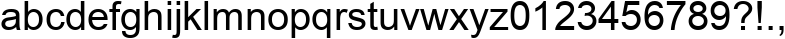

Expected text:
abcdefghijklmnopqrstuvwxyz0123456789?!.,
Text from OCR:
abcdefghijkllllmnopqrstuvwxyz011123456789?! ,



In [17]:
font = 'arial'
size = 40
text = CHARACTERS

TEST(text, font, size, 0.93, 0, 0)

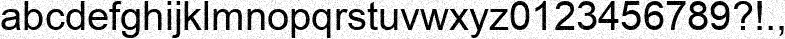

Expected text:
abcdefghijklmnopqrstuvwxyz0123456789?!.,
Text from OCR:
abcdefghijklllmnopqrstuvwxyz0123456789?!



In [18]:
font = 'arial'
size = 40
text = CHARACTERS

TEST(text, font, size, 0.93, 20, 0)

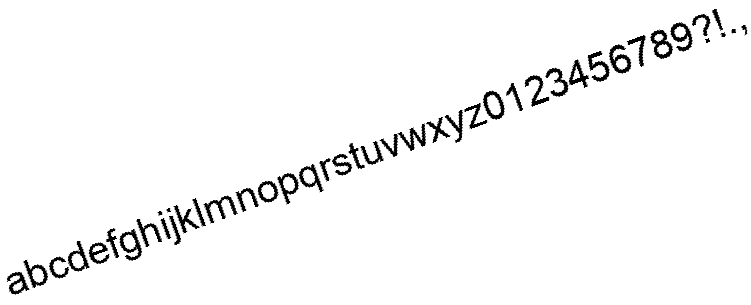

Expected text:
abcdefghijklmnopqrstuvwxyz0123456789?!.,
Text from OCR:
abcdefghijkllmnopqrstuvwxyz0123456789?! .



In [19]:
font = 'arial'
size = 40
text = CHARACTERS

TEST(text, font, size, 0.93, 0, 20)

Czcionka szeryfowa

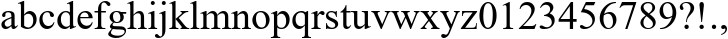

Expected text:
abcdefghijklmnopqrstuvwxyz0123456789?!.,
Text from OCR:
..
abcdefghlljk!!!!nmriopqrstuvwxyz0nn23456789?111



In [20]:
font = 'times'
size = 40
text = CHARACTERS

TEST(text, font, size, 0.93, 0, 0)

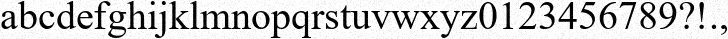

Expected text:
abcdefghijklmnopqrstuvwxyz0123456789?!.,
Text from OCR:
!!! .
abcdefghjkimnopqrstuvwxyz0123456789 ..ll .



In [21]:
font = 'times'
size = 40
text = CHARACTERS

TEST(text, font, size, 0.93, 10, 0)

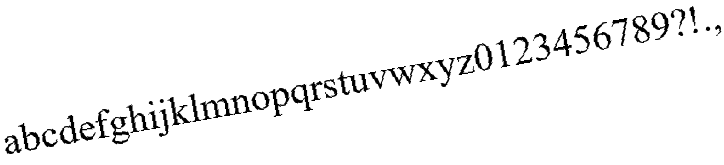

Expected text:
abcdefghijklmnopqrstuvwxyz0123456789?!.,
Text from OCR:
!!
abbcddefgh!!!!!!!jkiiimnopqrstttuvwxy ....0011123456789 !!ll



In [22]:
font = 'times'
size = 40
text = CHARACTERS

TEST(text, font, size, 0.9, 0, 10)

# LIVE DEMO

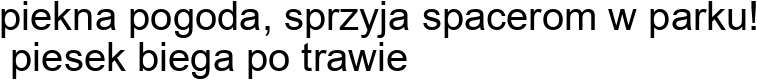

Expected text:
piekna pogoda, sprzyja spacerom w parku!
 piesek biega po trawie
Text from OCR:
piekna pogoda sprz,,,,ja spacerom w parku!
piesek biega po trawie



In [40]:
font = 'arial'
size = 40
text = 'piekna pogoda, sprzyja spacerom w parku!\npiesek biega po trawie'

TEST(text, font, size, 0.9342, 0, 0)

## Podsumowanie
Program wyraźnie działa lepiej w przypadku wykorzystania czcionek bezszeryfowych.  
W przypadku obrotu obrazu współczynnik zaufania musi być zmniejszony by zwiększyć poprawność działania.  
Program w przypadku obrazów zaszumionych radzi sobie wyraźnie gorzej z powodu niskiej jakości i trudności z wykrywaniem znaków.  